**Exploring regional luminosity and economic activity: A geocomputational notebook to process and analyze satellite nighttime lights imagery**




- [ ] Both: revise the title

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import contextily as cx

import plotly.express as px

import rasterio
from rasterio import plot as rioplot
from rasterio.mask import mask

from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import BetweenOLS
from linearmodels.panel.results import compare

import inequality

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# Load vector and raster files

In [2]:
#polygonsFile = gpd.read_file('data/vector/gdf_India36.geojson')
polygonsFile = gpd.read_file('data/vector/gdf_indiastates_datameet.json') 
#polygonsFile = gpd.read_file('data/vector/gdf_India33.geojson')
polygonsFile_bbox = polygonsFile.total_bounds

- [ ] Both: discuss the number of states

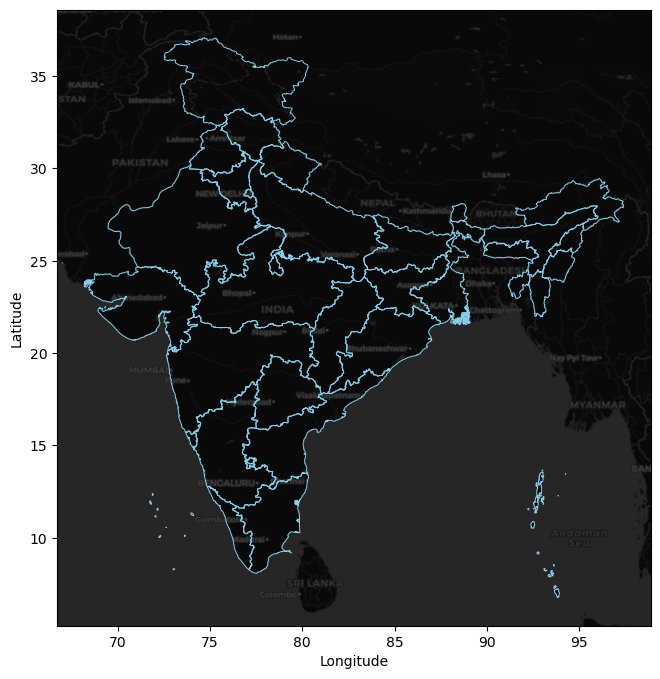

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
polygonsFile.boundary.plot(ax=plt.gca(), color='skyblue', linewidth = 0.7)
cx.add_basemap(ax=plt.gca(), crs=polygonsFile.crs.to_string(), source = cx.providers.CartoDB.DarkMatter, attribution=False)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('figures/boundaries.png',dpi=300, bbox_inches='tight')
plt.show()

In [4]:
rasterFile = rasterio.open('data/raster/NTL_1992.tif') 
rasterFile_window  = rasterFile.window(*polygonsFile_bbox)
rasterFile_clipped = rasterFile.read(1, window = rasterFile_window)

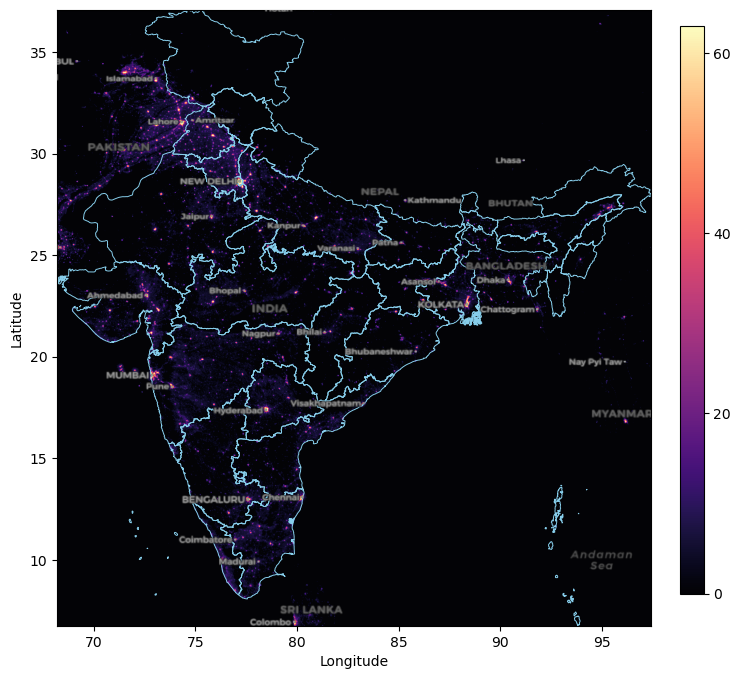

In [5]:
fig = plt.figure(figsize=(8,8))
plt.imshow(rasterFile_clipped, extent=polygonsFile_bbox[[0,2,1,3]], cmap='magma', alpha=0.99) # cmap: hot, inferno, plasma, magma, cividis
polygonsFile.boundary.plot(ax=plt.gca(), color='skyblue', linewidth = 0.7)
cx.add_basemap(ax=plt.gca(), crs=polygonsFile.crs.to_string(), source = cx.providers.CartoDB.DarkMatterOnlyLabels, attribution=False)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
cbaxes = fig.add_axes([0.92, 0.15, 0.03, 0.71])  # What is this?
plt.colorbar(cax=cbaxes, ticks=[0,20, 40, 60], orientation='vertical')
plt.savefig('figures/NTL_initial.png',dpi=300, bbox_inches='tight')
plt.show()

In [6]:
rasterFile = rasterio.open('data/raster/NTL_2019.tif') 
rasterFile_window  = rasterFile.window(*polygonsFile_bbox)
rasterFile_clipped = rasterFile.read(1, window = rasterFile_window)

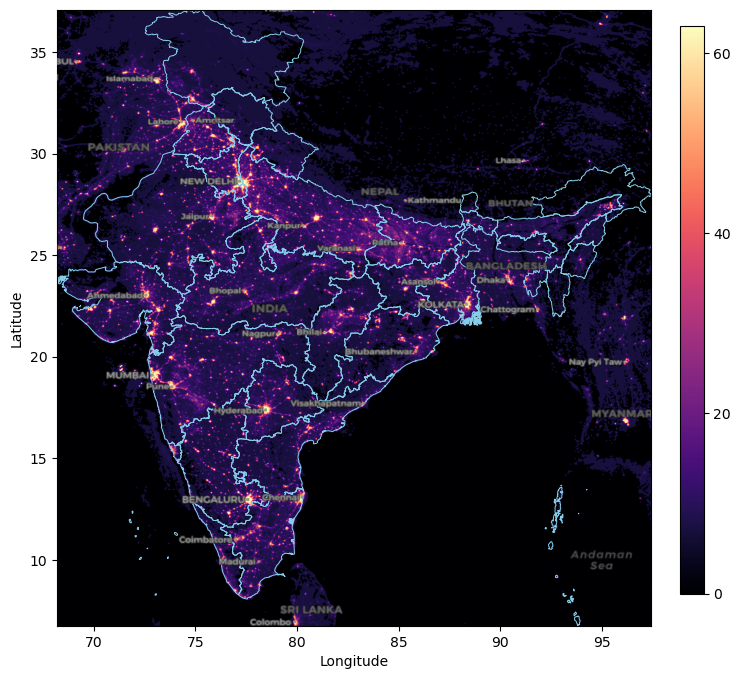

In [7]:
fig = plt.figure(figsize=(8,8))
plt.imshow(rasterFile_clipped, extent=polygonsFile_bbox[[0,2,1,3]], cmap='magma') # cmap: hot, inferno, plasma, magma, cividis
polygonsFile.boundary.plot(ax=plt.gca(), color='skyblue', linewidth = 0.7);
cx.add_basemap(ax=plt.gca(), crs=polygonsFile.crs.to_string(), source = cx.providers.CartoDB.DarkMatterOnlyLabels, attribution=False)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
cbaxes = fig.add_axes([0.92, 0.15, 0.03, 0.71]) 
plt.colorbar(cax=cbaxes, ticks=[0,20, 40, 60], orientation='vertical')
plt.savefig('figures/NTL_final.png',dpi=300, bbox_inches='tight')
plt.show()

# Compute zonal statistics

In [8]:
def clean_mask(geom, dataset=rasterFile, **mask_kw):
    mask_kw.setdefault('crop', True)
    mask_kw.setdefault('all_touched', True)
    mask_kw.setdefault('filled', False)
    masked, mask_transform = mask(dataset=dataset, shapes=(geom,),
                                  **mask_kw)
    return masked

In [9]:
gdf_NTL = polygonsFile.copy() # Initiating dataframe to store ntl zonal statistics

In [10]:
for year in range(1992, 2013):
    rasterFile = rasterio.open('/work/data/raster/NTL_'+str(year)+'.tif')
    def clean_mask(geom, dataset=rasterFile, **mask_kw):
        mask_kw.setdefault('crop', True)
        mask_kw.setdefault('all_touched', True)
        mask_kw.setdefault('filled', False)
        masked, mask_transform = mask(dataset=dataset, shapes=(geom,),
                                    **mask_kw)
        return masked
    gdf_NTL[str(year)] = polygonsFile.geometry.apply(clean_mask).apply(np.ma.sum)

In [11]:
gdf_NTL

ST_NM  \
0   Andaman & Nicobar Island   
1         Arunanchal Pradesh   
2                      Assam   
3                      Bihar   
4                 Chandigarh   
5               Chhattisgarh   
6     Dadara & Nagar Havelli   
7                Daman & Diu   
8                        Goa   
9                    Gujarat   
10                   Haryana   
11          Himachal Pradesh   
12         Jammu and Kashmir   
13                 Jharkhand   
14                 Karnataka   
15                    Kerala   
16               Lakshadweep   
17            Madhya Pradesh   
18               Maharashtra   
19                   Manipur   
20                 Meghalaya   
21                   Mizoram   
22                  Nagaland   
23              NCT of Delhi   
24                Puducherry   
25                    Punjab   
26                 Rajasthan   
27                    Sikkim   
28                Tamil Nadu   
29                 Telangana   
30                   Tripura   
31             Uttar Pradesh   
32               Uttarakhand   
33               West Bengal   
34                    Odisha   
35            Andhra Pradesh   

                                             geometry     1992     1993  \
0   MULTIPOLYGON (((93.84861 7.24051, 93.80986 7.2...     2723     4570   
1   POLYGON ((95.23730 26.67984, 95.25969 26.67984...     5021     4741   
2   POLYGON ((95.19587 27.03716, 95.21414 27.02763...   139992   153762   
3   POLYGON ((88.11223 26.53886, 88.09970 26.50862...    63276    91756   
4   POLYGON ((76.84147 30.75996, 76.82527 30.76284...    10119    10013   
5   POLYGON ((83.94652 23.62299, 83.93692 23.59404...   130580   112481   
6   POLYGON ((73.20657 20.12216, 73.18615 20.14012...     1141     2176   
7   MULTIPOLYGON (((72.80198 20.37417, 72.82333 20...     2096     2170   
8   POLYGON ((74.11877 15.65246, 74.07307 15.62834...    19991    23978   
9   MULTIPOLYGON (((72.67653 21.15570, 72.66486 21...   658161   798208   
10  POLYGON ((77.12601 30.56392, 77.17071 30.59520...   467035   429662   
11  POLYGON ((78.39998 32.52597, 78.32782 32.47225...    34052    33561   
12  POLYGON ((78.39998 32.52597, 78.42715 32.53132...    81188    80902   
13  POLYGON ((87.79328 25.22107, 87.78902 25.24674...   111218   123176   
14  MULTIPOLYGON (((74.30911 15.79856, 74.28975 15...   401442   538070   
15  POLYGON ((76.43138 11.66633, 76.40998 11.69008...   194770   233528   
16  MULTIPOLYGON (((74.10131 11.20431, 74.12313 11...      124      184   
17  POLYGON ((82.81553 23.96198, 82.80649 23.97552...   580640   673188   
18  POLYGON ((80.66342 21.33138, 80.62463 21.31976...  1155544  1369309   
19  POLYGON ((94.68085 25.45317, 94.65717 25.45055...    10012    13264   
20  POLYGON ((92.43839 25.03162, 92.46373 25.03496...     8567    14107   
21  POLYGON ((92.99965 24.40013, 92.97944 24.40659...     2310     4130   
22  POLYGON ((95.23730 26.67984, 95.23582 26.70580...     4401     6824   
23  POLYGON ((77.19721 28.86152, 77.17491 28.85535...    93034    90854   
24  MULTIPOLYGON (((79.79140 10.99260, 79.76008 11...     8579     9237   
25  POLYGON ((76.73903 30.93897, 76.72617 30.95990...   536188   535073   
26  POLYGON ((74.28847 29.95535, 74.07842 29.96971...   634578   726543   
27  POLYGON ((88.75870 27.14800, 88.76543 27.17176...     1471     1711   
28  MULTIPOLYGON (((79.32715 9.29651, 79.33324 9.3...   618949   743196   
29  POLYGON ((81.05614 17.79097, 81.05363 17.79123...   382276   510325   
30  POLYGON ((92.23342 24.50171, 92.22108 24.50131...    16730    24309   
31  MULTIPOLYGON (((79.39956 25.03069, 79.42431 25...   824818   865467   
32  POLYGON ((80.07035 28.82923, 80.06361 28.84526...    53655    58366   
33  MULTIPOLYGON (((88.49771 21.59976, 88.48611 21...   325754   358691   
34  POLYGON ((86.72789 22.21930, 86.68731 22.22354...   129011   144741   
35  MULTIPOLYGON (((81.10610 17.82436, 81.09749 17...   396857   581672   

       1994     1995     1996     1997     1998     1999  ... 

In [12]:
gdf_NTL.drop("geometry", axis=1).describe().round(2)

1992        1993        1994        1995        1996        1997  \
count       36.00       36.00       36.00       36.00       36.00       36.00   
mean    225175.08   260387.36   261330.78   335656.28   346549.83   328257.78   
std     290363.17   337982.31   335898.55   433086.13   445804.10   424632.37   
min        124.00      184.00      199.00      207.00      244.00      235.00   
25%       8576.00     9819.00    10075.75    12252.75    12107.75    12343.25   
50%      87111.00    91305.00    88682.00   112816.50   122270.00   108022.50   
75%     398003.25   516512.00   454671.25   580918.50   640551.75   602666.25   
max    1155544.00  1369309.00  1270980.00  1656383.00  1749491.00  1689059.00   

             1998        1999        2000        2001  ...        2003  \
count       36.00       36.00       36.00       36.00  ...       36.00   
mean    378176.92   388001.33   421383.89   428531.86  ...   407353.17   
std     491232.09   505016.96   544004.21   558922.96  ...   529402.21   
min        270.00      238.00      267.00      299.00  ...      242.00   
25%      13111.25    14169.50    14837.50    14429.00  ...    13347.00   
50%     134539.00   124665.50   147549.50   147739.50  ...   145876.00   
75%     704726.50   752094.75   792524.25   824130.25  ...   733791.25   
max    1992298.00  1997927.00  2206032.00  2217526.00  ...  2072113.00   

             2004        2005        2006        2007        2008        2009  \
count       36.00       36.00       36.00       36.00       36.00       36.00   
mean    469789.31   433914.28   397105.94   490301.39   465267.89   507197.17   
std     577544.34   523492.87   471733.74   586885.03   559685.44   617669.38   
min        248.00      239.00      163.00      221.00      189.00      227.00   
25%      15644.25    13829.75    13298.50    15380.25    14230.50    14266.25   
50%     174651.00   187047.00   172316.50   208011.00   200819.00   198193.00   
75%     926419.00   839462.75   735775.25   968192.75   891522.25  1011861.25   
max    2182136.00  1859647.00  1510797.00  2035985.00  2006425.00  2033592.00   

             2010        2011        2012  
count       36.00       36.00       36.00  
mean    499292.53   529649.64   585282.25  
std     598573.58   642351.24   711705.13  
min        314.00      308.00      370.00  
25%      16601.50    17650.00    17102.00  
50%     233447.50   223977.50   261034.00  
75%     882426.75   911350.00  1050788.00  
max    1983944.00  2401028.00  2656001.00  

[8 rows x 21 columns]

In [13]:
gdf_NTL.to_file("data/vector/gdf_NTL.geojson", driver="GeoJSON")

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Create panel data structures

- [x] Carlos: export both long and wide form panel data structures

First, long form:

In [14]:
df_NTL = gpd.read_file('data/vector/gdf_NTL.geojson').drop("geometry", axis=1)
df_NTL

ST_NM     1992     1993     1994     1995     1996  \
0   Andaman & Nicobar Island     2723     4570     4461     6177     5954   
1         Arunanchal Pradesh     5021     4741     3929     4098     6654   
2                      Assam   139992   153762   162325   168726   186699   
3                      Bihar    63276    91756    85665   116902   128169   
4                 Chandigarh    10119    10013     9874    10350    10211   
5               Chhattisgarh   130580   112481   141469   216128   204751   
6     Dadara & Nagar Havelli     1141     2176     2132     3409     4204   
7                Daman & Diu     2096     2170     2508     3429     3696   
8                        Goa    19991    23978    24779    28677    30392   
9                    Gujarat   658161   798208   794737  1033390  1032440   
10                   Haryana   467035   429662   404011   533661   580924   
11          Himachal Pradesh    34052    33561    30991    50406    61112   
12         Jammu and Kashmir    81188    80902    75868   108731   116371   
13                 Jharkhand   111218   123176   124451   149989   148314   
14                 Karnataka   401442   538070   613171   745163   791039   
15                    Kerala   194770   233528   224945   272608   258789   
16               Lakshadweep      124      184      199      207      244   
17            Madhya Pradesh   580640   673188   787455  1104977  1101680   
18               Maharashtra  1155544  1369309  1270980  1656383  1749491   
19                   Manipur    10012    13264    10538    12887    12740   
20                 Meghalaya     8567    14107    15360    21175    15048   
21                   Mizoram     2310     4130     4735     4445     5119   
22                  Nagaland     4401     6824     5678     5501     7576   
23              NCT of Delhi    93034    90854    91699    98292   100595   
24                Puducherry     8579     9237    10143    13031    13390   
25                    Punjab   536188   535073   482758   656769   684369   
26                 Rajasthan   634578   726543   772612  1005292  1074881   
27                    Sikkim     1471     1711     1726     3059     2994   
28                Tamil Nadu   618949   743196   758269   971989   936140   
29                 Telangana   382276   510325   445309   555635   625946   
30                   Tripura    16730    24309    19087    22502    23550   
31             Uttar Pradesh   824818   865467   896775  1040555  1032862   
32               Uttarakhand    53655    58366    57185    79204    80901   
33               West Bengal   325754   358691   357550   428291   460789   
34                    Odisha   129011   144741   169030   235561   256115   
35            Andhra Pradesh   396857   581672   545504   716027   721645   

       1997     1998     1999     2000  ...     2003     2004     2005  \
0      4542     5893     5558     6557  ...     6501     9106     6837   
1      5566     7173     9719     7073  ...     7204    10350     8976   
2    189375   193314   203013   210810  ...   171618   232512   220817   
3    112665   149988   124548   163528  ...   153654   174184   185104   
4     10352    10778    10988    10987  ...    11256    10703    11114   
5    196664   225705   156840   228804  ...   231219   355031   338299   
6      4798     5573     6133     6545  ...     7743     9744     9090   
7      4401     4077     4471     5010  ...     5671     5661     5528   
8     28947    34950    34726    40442  ...    47886    52428    52099   
9   1115154  1157022  1266529  1376294  ...  1253938  1299464  1203519   
10   575899   574142   601228   651400  ...   675963   780597   748214   
11    57919    78646   104091   124894  ...   137343   173202   155668   
12   103380   133512   124783   136443  ...   138098   175118   189688   
13   126992   135566   139869   158656  ...   158898   198096   188990   
14   754688   999715  1024077  1123823  ...  1129626  1289241  

In [15]:
df_GDP = pd.read_csv("data/tabular/df_GDP_India36.csv")
df_GDP

region selectedRegion          1990          1991  \
0                 Uttar Pradesh            NaN  2.470755e+08  2.492645e+08   
1                   Maharashtra    Maharashtra  2.000026e+08  2.016145e+08   
2                     Telangana            NaN  1.620218e+08  1.631990e+08   
3                         Bihar          Bihar  1.272075e+08  1.283717e+08   
4                Madhya Pradesh            NaN  1.217071e+08  1.227653e+08   
5                   West Bengal            NaN  1.160517e+08  1.170596e+08   
6                       Gujarat            NaN  1.029060e+08  1.037340e+08   
7                Andhra Pradesh            NaN  1.021261e+08  1.030178e+08   
8                    Tamil Nadu            NaN  8.959185e+07  9.035507e+07   
9                     Karnataka            NaN  8.891273e+07  8.967114e+07   
10                    Jharkhand            NaN  8.357128e+07  8.429436e+07   
11                    Rajasthan            NaN  8.023605e+07  8.093705e+07   
12                 Chhattisgarh            NaN  6.891411e+07  6.949627e+07   
13                       Kerala         Kerala  6.720404e+07  6.774802e+07   
14                       Punjab         Punjab  6.032118e+07  6.079300e+07   
15                  Uttarakhand            NaN  5.847588e+07  5.892906e+07   
16                 NCT of Delhi          Delhi  5.698460e+07  5.736087e+07   
17                      Haryana            NaN  4.264814e+07  4.299942e+07   
18                       Odisha            NaN  3.722038e+07  3.756291e+07   
19                        Assam            NaN  3.019601e+07  3.047141e+07   
20                   Puducherry            NaN  1.100779e+07  1.108174e+07   
21             Himachal Pradesh            NaN  9.725529e+06  9.808368e+06   
22            Jammu and Kashmir            NaN  8.382191e+06  8.451817e+06   
23                      Tripura            NaN  4.142928e+06  4.179843e+06   
24       Dadra and Nagar Haveli            NaN  4.020551e+06  4.050129e+06   
25                          Goa            Goa  3.242630e+06  3.267770e+06   
26                      Manipur            NaN  2.969333e+06  2.995719e+06   
27                    Meghalaya            NaN  2.954631e+06  2.980743e+06   
28                     Nagaland            NaN  2.789343e+06  2.812378e+06   
29  Andaman and Nicobar Islands            NaN  2.106129e+06  2.120380e+06   
30            Arunachal Pradesh            NaN  1.584485e+06  1.598145e+06   
31                       Sikkim         Sikkim  1.523894e+06  1.535670e+06   
32                      Mizoram            NaN  1.284898e+06  1.295907e+06   
33                Daman and Diu            NaN  9.557955e+05  9.623571e+05   
34                  Lakshadweep            NaN  5.086716e+05  5.119829e+05   
35                  Chandigarth    Chandigarth  2.500403e+05  2.518642e+05   

            1992          1993          1994          1995          1996  \
0   2.626260e+08  2.682413e+08  2.789044e+08  2.925654e+08  3.069652e+08   
1   2.128908e+08  2.268613e+08  2.461944e+08  2.695175e+08  2.949227e+08   
2   1.727044e+08  1.772760e+08  1.857114e+08  1.965366e+08  2.080707e+08   
3   1.351438e+08  1.366986e+08  1.406898e+08  1.460419e+08  1.516232e+08   
4   1.294045e+08  1.339848e+08  1.412362e+08  1.502001e+08  1.597486e+08   
5   1.233937e+08  1.291518e+08  1.375672e+08  1.477724e+08  1.586905e+08   
6   1.095398e+08  1.159777e+08  1.251037e+08  1.361818e+08  1.482266e+08   
7   1.085781e+08  1.163156e+08  1.267013e+08  1.390893e+08  1.525567e+08   
8   9.528778e+07  1.031916e+08  1.136387e+08  1.261129e+08  1.398118e+08   
9   9.456362e+07  1.001500e+08  1.080239e+08  1.175866e+08  1.280305e+08   
10  8.886345e+07  9.096379e+07  9.482795e+07  9.976197e+07  1.049893e+08   
11  8.530442e+07  9.046666e+07  9.769866e+07  1.064813e+08  1.161056e+08   
12  7.330465e+07  7.506797e+07  7.831338e+07  8.246039e+07  8.685764e+07   
13  7.153019e+07  7.167484e+07  7.310943e+07  7.517964e+07  7.723211e+07  

In [16]:
df2_NTL = pd.melt(df_NTL, id_vars= 'ST_NM', value_vars=[str(x) for x in range(1992,2013)])
df2_NTL.columns = ["region", "year", "NTL"] 

In [17]:
df2_GDP = pd.melt(df_GDP, id_vars= ['region', 'selectedRegion'], value_vars=[str(x) for x in range(1992,2013)])
df2_GDP.columns = ["region", "selectedRegion", "year", "GDP"] 

In [18]:
df = pd.merge(df2_GDP, df2_NTL, on=['region','year'], how='inner')

In [19]:
df['lnNTL'] = np.log(0.01 + df['NTL'])
df['lnGDP'] = np.log(df['GDP'])

In [20]:
df

region selectedRegion  year           GDP      NTL      lnNTL  \
0     Uttar Pradesh            NaN  1992  2.626260e+08   824818  13.622918   
1       Maharashtra    Maharashtra  1992  2.128908e+08  1155544  13.960082   
2         Telangana            NaN  1992  1.727044e+08   382276  12.853898   
3             Bihar          Bihar  1992  1.351438e+08    63276  11.055262   
4    Madhya Pradesh            NaN  1992  1.294045e+08   580640  13.271886   
..              ...            ...   ...           ...      ...        ...   
646       Meghalaya            NaN  2012  2.347987e+07    37118  10.521858   
647        Nagaland            NaN  2012  2.397720e+07    13515   9.511556   
648          Sikkim         Sikkim  2012  3.486618e+06    12338   9.420440   
649         Mizoram            NaN  2012  1.675361e+07     7490   8.921325   
650     Lakshadweep            NaN  2012  9.738393e+05      370   5.913530   

         lnGDP  
0    19.386242  
1    19.176290  
2    18.967092  
3    18.721850  
4    18.678454  
..         ...  
646  16.971654  
647  16.992614  
648  15.064443  
649  16.634124  
650  13.789002  

[651 rows x 7 columns]

In [21]:
df.describe().round(2)

GDP         NTL   lnNTL   lnGDP
count  6.510000e+02      651.00  651.00  651.00
mean   1.286501e+08   474121.24   11.88   17.79
std    1.311032e+08   536002.95    2.10    1.70
min    5.429265e+05      124.00    4.82   13.20
25%    1.507687e+07    34389.00   10.45   16.53
50%    9.857719e+07   214119.00   12.27   18.41
75%    1.960717e+08   833387.50   13.63   19.09
max    7.146252e+08  2656001.00   14.79   20.39

In [22]:
df.to_csv('data/tabular/df_NTL_GDP_lnNTL_lnGDP.csv', index = False)

Next, wide form with geometry column

In [23]:
# Pivot panel data from long form to wide form
df_lnNTL = df.pivot_table(
    index=['region'],
    columns='year',
    values='lnNTL').reset_index(drop=False)
# Make sure the column names are strings
df_lnNTL.columns = df_lnNTL.columns.astype(str)


In [24]:
# Merge with polygonsFile
gdf_lnNTL = pd.merge(polygonsFile, df_lnNTL, left_on= 'ST_NM', right_on= 'region', how='inner')
gdf_lnNTL

ST_NM                                           geometry  \
0               Assam  POLYGON ((95.19587 27.03716, 95.21414 27.02763...   
1               Bihar  POLYGON ((88.11223 26.53886, 88.09970 26.50862...   
2        Chhattisgarh  POLYGON ((83.94652 23.62299, 83.93692 23.59404...   
3                 Goa  POLYGON ((74.11877 15.65246, 74.07307 15.62834...   
4             Gujarat  MULTIPOLYGON (((72.67653 21.15570, 72.66486 21...   
5             Haryana  POLYGON ((77.12601 30.56392, 77.17071 30.59520...   
6    Himachal Pradesh  POLYGON ((78.39998 32.52597, 78.32782 32.47225...   
7   Jammu and Kashmir  POLYGON ((78.39998 32.52597, 78.42715 32.53132...   
8           Jharkhand  POLYGON ((87.79328 25.22107, 87.78902 25.24674...   
9           Karnataka  MULTIPOLYGON (((74.30911 15.79856, 74.28975 15...   
10             Kerala  POLYGON ((76.43138 11.66633, 76.40998 11.69008...   
11        Lakshadweep  MULTIPOLYGON (((74.10131 11.20431, 74.12313 11...   
12     Madhya Pradesh  POLYGON ((82.81553 23.96198, 82.80649 23.97552...   
13        Maharashtra  POLYGON ((80.66342 21.33138, 80.62463 21.31976...   
14            Manipur  POLYGON ((94.68085 25.45317, 94.65717 25.45055...   
15          Meghalaya  POLYGON ((92.43839 25.03162, 92.46373 25.03496...   
16            Mizoram  POLYGON ((92.99965 24.40013, 92.97944 24.40659...   
17           Nagaland  POLYGON ((95.23730 26.67984, 95.23582 26.70580...   
18       NCT of Delhi  POLYGON ((77.19721 28.86152, 77.17491 28.85535...   
19         Puducherry  MULTIPOLYGON (((79.79140 10.99260, 79.76008 11...   
20             Punjab  POLYGON ((76.73903 30.93897, 76.72617 30.95990...   
21          Rajasthan  POLYGON ((74.28847 29.95535, 74.07842 29.96971...   
22             Sikkim  POLYGON ((88.75870 27.14800, 88.76543 27.17176...   
23         Tamil Nadu  MULTIPOLYGON (((79.32715 9.29651, 79.33324 9.3...   
24          Telangana  POLYGON ((81.05614 17.79097, 81.05363 17.79123...   
25            Tripura  POLYGON ((92.23342 24.50171, 92.22108 24.50131...   
26      Uttar Pradesh  MULTIPOLYGON (((79.39956 25.03069, 79.42431 25...   
27        Uttarakhand  POLYGON ((80.07035 28.82923, 80.06361 28.84526...   
28        West Bengal  MULTIPOLYGON (((88.49771 21.59976, 88.48611 21...   
29             Odisha  POLYGON ((86.72789 22.21930, 86.68731 22.22354...   
30     Andhra Pradesh  MULTIPOLYGON (((81.10610 17.82436, 81.09749 17...   

               region       1992       1993       1994       1995       1996  \
0               Assam  11.849341  11.943161  11.997356  12.036031  12.137253   
1               Bihar  11.055262  11.426888  11.358200  11.669091  11.761105   
2        Chhattisgarh  11.779741  11.630540  11.859836  12.283626  12.229550   
3                 Goa   9.903038  10.084892  10.117752  10.263851  10.321935   
4             Gujarat  13.397205  13.590125  13.585767  13.848355  13.847436   
5             Haryana  13.054160  12.970754  12.909197  13.187516  13.272375   
6    Himachal Pradesh  10.435644  10.421120  10.341452  10.827866  11.020464   
7   Jammu and Kashmir  11.304523  11.300994  11.236750  11.596632  11.664539   
8           Jharkhand  11.619248  11.721370  11.731667  11.918317  11.907087   
9           Karnataka  12.902818  13.195744  13.326399  13.521358  13.581103   
10             Kerala  12.179575  12.361057  12.323611  12.515790  12.463768   
11        Lakshadweep   4.820362   5.214990   5.293355   5.332767   5.497209   
12     Madhya Pradesh  13.271886  13.419780  13.576562  13.915335  13.912347   
13        Maharashtra  13.960082  14.129817  14.055299  14.320147  14.374835   
14            Manipur   9.211541   9.492810   9.262744   9.463975   9.452503   
15          Meghalaya   9.055674   9.554427   9.639523   9.960577   9.619001   
16            Mizoram   7.745007   8.326035   8.462739   8.399537   8.540716   
17           Nagaland   8.389589   8.828203   8.644356   8.612687   8.932742   
18       NCT of Delhi  11.440720  11.417009  11.426267  11.4956

In [25]:
gdf_lnNTL.to_file("data/vector/gdf_lnNTL.geojson", driver="GeoJSON")

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [26]:
# Pivot panel data from long form to wide form
df_lnGDP = df.pivot_table(
    index=['region'],
    columns='year',
    values='lnGDP').reset_index(drop=False)
# Make sure the column names are strings
df_lnGDP.columns = df_lnGDP.columns.astype(str)


In [27]:
# Merge with polygonsFile
gdf_lnGDP = pd.merge(polygonsFile, df_lnGDP, left_on= 'ST_NM', right_on= 'region', how='inner')
gdf_lnGDP

ST_NM                                           geometry  \
0               Assam  POLYGON ((95.19587 27.03716, 95.21414 27.02763...   
1               Bihar  POLYGON ((88.11223 26.53886, 88.09970 26.50862...   
2        Chhattisgarh  POLYGON ((83.94652 23.62299, 83.93692 23.59404...   
3                 Goa  POLYGON ((74.11877 15.65246, 74.07307 15.62834...   
4             Gujarat  MULTIPOLYGON (((72.67653 21.15570, 72.66486 21...   
5             Haryana  POLYGON ((77.12601 30.56392, 77.17071 30.59520...   
6    Himachal Pradesh  POLYGON ((78.39998 32.52597, 78.32782 32.47225...   
7   Jammu and Kashmir  POLYGON ((78.39998 32.52597, 78.42715 32.53132...   
8           Jharkhand  POLYGON ((87.79328 25.22107, 87.78902 25.24674...   
9           Karnataka  MULTIPOLYGON (((74.30911 15.79856, 74.28975 15...   
10             Kerala  POLYGON ((76.43138 11.66633, 76.40998 11.69008...   
11        Lakshadweep  MULTIPOLYGON (((74.10131 11.20431, 74.12313 11...   
12     Madhya Pradesh  POLYGON ((82.81553 23.96198, 82.80649 23.97552...   
13        Maharashtra  POLYGON ((80.66342 21.33138, 80.62463 21.31976...   
14            Manipur  POLYGON ((94.68085 25.45317, 94.65717 25.45055...   
15          Meghalaya  POLYGON ((92.43839 25.03162, 92.46373 25.03496...   
16            Mizoram  POLYGON ((92.99965 24.40013, 92.97944 24.40659...   
17           Nagaland  POLYGON ((95.23730 26.67984, 95.23582 26.70580...   
18       NCT of Delhi  POLYGON ((77.19721 28.86152, 77.17491 28.85535...   
19         Puducherry  MULTIPOLYGON (((79.79140 10.99260, 79.76008 11...   
20             Punjab  POLYGON ((76.73903 30.93897, 76.72617 30.95990...   
21          Rajasthan  POLYGON ((74.28847 29.95535, 74.07842 29.96971...   
22             Sikkim  POLYGON ((88.75870 27.14800, 88.76543 27.17176...   
23         Tamil Nadu  MULTIPOLYGON (((79.32715 9.29651, 79.33324 9.3...   
24          Telangana  POLYGON ((81.05614 17.79097, 81.05363 17.79123...   
25            Tripura  POLYGON ((92.23342 24.50171, 92.22108 24.50131...   
26      Uttar Pradesh  MULTIPOLYGON (((79.39956 25.03069, 79.42431 25...   
27        Uttarakhand  POLYGON ((80.07035 28.82923, 80.06361 28.84526...   
28        West Bengal  MULTIPOLYGON (((88.49771 21.59976, 88.48611 21...   
29             Odisha  POLYGON ((86.72789 22.21930, 86.68731 22.22354...   
30     Andhra Pradesh  MULTIPOLYGON (((81.10610 17.82436, 81.09749 17...   

               region       1992       1993       1994       1995       1996  \
0               Assam  17.283796  17.308714  17.351086  17.402135  17.453440   
1               Bihar  18.721850  18.733289  18.762068  18.799404  18.836909   
2        Chhattisgarh  18.110135  18.133904  18.176229  18.227829  18.279781   
3                 Goa  15.054885  15.140251  15.244271  15.357300  15.469950   
4             Gujarat  18.511799  18.568908  18.644653  18.729501  18.814253   
5             Haryana  17.630628  17.697365  17.783317  17.879171  17.975811   
6    Himachal Pradesh  16.151904  16.252503  16.371664  16.500375  16.629729   
7   Jammu and Kashmir  16.003632  16.230677  16.447758  16.653392  16.843562   
8           Jharkhand  18.302612  18.325972  18.367575  18.418298  18.469369   
9           Karnataka  18.364783  18.422179  18.497863  18.582686  18.667779   
10             Kerala  18.085630  18.087650  18.107468  18.135391  18.162326   
11        Lakshadweep  13.204729  13.232338  13.281451  13.341302  13.401542   
12     Madhya Pradesh  18.678454  18.713237  18.765944  18.827479  18.889112   
13        Maharashtra  19.176290  19.239849  19.321632  19.412144  19.502224   
14            Manipur  14.964835  15.025377  15.103772  15.191163  15.278937   
15          Meghalaya  14.959958  14.976903  15.011231  15.053886  15.096268   
16            Mizoram  14.127743  14.208140  14.306055  14.412450  14.518530   
17           Nagaland  14.903415  14.926270  14.965263  15.010981  15.054577   
18       NCT of Delhi  17.923313  18.039640  18.174374  18.3172

In [28]:
gdf_lnGDP.to_file("data/vector/gdf_lnGDP.geojson", driver="GeoJSON")

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Interactive exploration

- [x] Carlos: Add interactive exploration: time series, maps, scatterplots

In [29]:
px.line(df, x = 'year',y = 'lnNTL', color = 'region')

In [30]:
px.line(df, x = 'year',y = 'lnGDP', color = 'region')

In [47]:
gdf_lnNTL.explore(
    column='1992',
    tooltip=['region', '1992'],
    k = 6,
    scheme = 'user_defined', # user_defined Quantiles, EqualInterval, BoxPlot, FisherJenks
    classification_kwds={'bins':[9.36, 10.50, 12.31, 13.96, 14.76, 15.36]},
    cmap = 'magma', # hot, cividis, plasma, magma, inferno, coolwarm, viridis
    legend=True,
    tiles = 'CartoDB dark_matter',  # CartoDB dark_matter OpenStreetMap, Stamen Terrain, Stamen Toner, Stamen Watercolor, CartoDB positron, CartoDB dark_mat,
    style_kwds =dict(color="darkgrey", weight=0.8),
    legend_kwds=dict(colorbar=False)
)

In [48]:
gdf_lnNTL.explore(
    column='2012',
    tooltip=['region', '2012'],
    k = 6,
    scheme = 'FisherJenks', # Quantiles, EqualInterval, BoxPlot, FisherJenks
    cmap = 'magma', # hot, cividis, plasma, magma, inferno, coolwarm, viridis
    legend=True,
    tiles = 'CartoDB dark_matter',  # CartoDB dark_matter OpenStreetMap, Stamen Terrain, Stamen Toner, Stamen Watercolor, CartoDB positron, CartoDB dark_mat,
    style_kwds =dict(color="darkgrey", weight=0.8),
    legend_kwds=dict(colorbar=False)
)

In [49]:
gdf_lnGDP.explore(
    column='1992',
    tooltip=['region', '1992'],
    k = 6,
    scheme = 'user_defined', # user_defined Quantiles, EqualInterval, BoxPlot, FisherJenks
    classification_kwds={'bins':[14.66, 16.28, 17.05, 19.10, 20.15, 20.89]},
    cmap = 'magma', # hot, cividis, plasma, magma, inferno, coolwarm, viridis
    legend=True,
    tiles = 'CartoDB dark_matter',  # CartoDB dark_matter OpenStreetMap, Stamen Terrain, Stamen Toner, Stamen Watercolor, CartoDB positron, CartoDB dark_mat,
    style_kwds =dict(color="darkgrey", weight=0.8),
    legend_kwds=dict(colorbar=False)
)

In [50]:
gdf_lnGDP.explore(
    column='2012',
    tooltip=['region', '2012'],
    k = 6,
    scheme = 'FisherJenks', # Quantiles, EqualInterval, BoxPlot, FisherJenks
    cmap = 'magma', # hot, cividis, plasma, magma, inferno, coolwarm, viridis
    legend=True,
    tiles = 'CartoDB dark_matter',  # CartoDB dark_matter OpenStreetMap, Stamen Terrain, Stamen Toner, Stamen Watercolor, CartoDB positron, CartoDB dark_mat,
    style_kwds =dict(color="darkgrey", weight=0.8),
    legend_kwds=dict(colorbar=False)
)

In [35]:
fig = px.scatter(
    df,
    x="lnNTL",
    y="lnGDP",
    range_x= [6, 16.5],
    range_y= [12, 22],
    hover_name="region",
    text= 'selectedRegion',
    animation_frame = 'year',
    trendline="ols",
    #marginal_x="histogram",
    #marginal_y="histogram"
    )

fig.update_traces(textposition='top center')
fig.show()

# Panel regression analysis

- [x] Carlos: add panel regressions

- [x] Carlos: export regression table as latex file

In [36]:
df_panel = pd.read_csv('data/tabular/df_NTL_GDP_lnNTL_lnGDP.csv').set_index(['region', 'year'])

In [37]:
table = {
    '(1) Pooled':    PooledOLS.from_formula(formula  = 'lnGDP ~ 1 + lnNTL', data=df_panel).fit(cov_type='clustered'),
    '(2) Between':   BetweenOLS.from_formula(formula = 'lnGDP ~ 1 + lnNTL', data=df_panel).fit(cov_type='clustered'),
    '(3) Within1fe': PanelOLS.from_formula(formula   = 'lnGDP ~ 1 + lnNTL + EntityEffects', data=df_panel).fit(cov_type='clustered'),
    '(4) Within2fe': PanelOLS.from_formula(formula   = 'lnGDP ~ 1 + lnNTL + EntityEffects + TimeEffects', data=df_panel).fit(cov_type='clustered')
}

In [38]:
compare(table).summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                                Model Comparison                                
================================================================================
                           (1) Pooled    (2) Between (3) Within1fe (4) Within2fe
--------------------------------------------------------------------------------
Dep. Variable                   lnGDP          lnGDP         lnGDP         lnGDP
Estimator                   PooledOLS     BetweenOLS      PanelOLS      PanelOLS
No. Observations                  651             31           651           651
Cov. Est.                   Clustered      Clustered     Clustered     Clustered
R-squared                      0.8799         0.9057        0.5434        0.0003
R-Squared (Within)             0.5179         0.5165        0.5434        0.0237
R-Squared (Between)            0.9057         0.9057        0.8317        0.0505
R-Squared (Overall)            0.8799         0.8799        0.8126        0.0488
F-statistic                    4756.9         278.62        736.67        0.2058
P-value (F-stat)               0.0000         0.0000        0.0000        0.6502
=====================     ===========   ============   ===========   ===========
Intercept                      8.7652         8.8296        6.2670        17.539
                             (65.559)       (17.000)      (12.080)      (28.125)
lnNTL                          0.7601         0.7547        0.9704        0.0214
                             (72.394)       (18.392)      (22.164)      (0.4071)
======================= ============= ============== ============= =============
Effects                                                     Entity        Entity
                                                                            Time
--------------------------------------------------------------------------------

T-stats reported in parentheses
"""

In [39]:
print(compare(table).summary.as_latex(), file=open('tables/panel_regression.txt','a'))
print(compare(table).summary.as_latex(), file=open('tables/panel_regression.tex','a'))

# Inequality dynamics

- [x] Add inequality dynamics

In [40]:
def gini_by_col(column):
    return inequality.gini.Gini(column.values).g

In [41]:
def theil_by_col(column):
    return inequality.theil.Theil(column.values).T

In [42]:
years = np.arange(1992, 2012).astype(str)

In [43]:
gini_lnGDP = gdf_lnGDP[years].apply(gini_by_col, axis=0).to_frame('Gini_lnGDP')
gini_lnNTL = gdf_lnNTL[years].apply(gini_by_col, axis=0).to_frame('Gini_lnNTL')

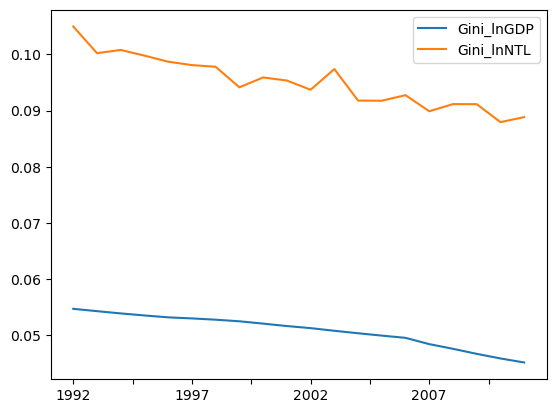

In [44]:
df_gini = pd.merge(gini_lnGDP, gini_lnNTL, left_index=True, right_index=True)
df_gini.plot();

In [45]:
theil_lnGDP = gdf_lnGDP[years].apply(theil_by_col, axis=0).to_frame('Theil_lnGDP')
theil_lnNTL = gdf_lnNTL[years].apply(theil_by_col, axis=0).to_frame('Theil_lnNTL')

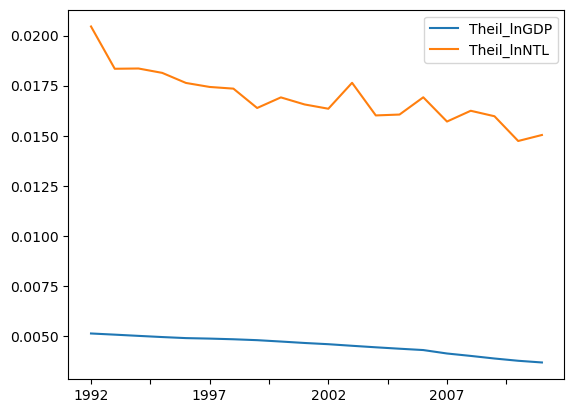

In [46]:
df_theil = pd.merge(theil_lnGDP, theil_lnNTL, left_index=True, right_index=True)
df_theil.plot();

# References

The nightime lights data is from Li, Xuecao; Zhou, Yuyu; zhao, Min; Zhao, Xia (2020): Harmonization of DMSP and VIIRS nighttime light data from 1992-2020 at the global scale. figshare. Dataset. https://doi.org/10.6084/m9.figshare.9828827.v5   

Reference: https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html

https://openjournals.wu.ac.at/ojs/index.php/region/article/view/295

https://darribas.org/gds_env/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=16c6ea55-d280-4412-aad9-a5cba1b9721e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>